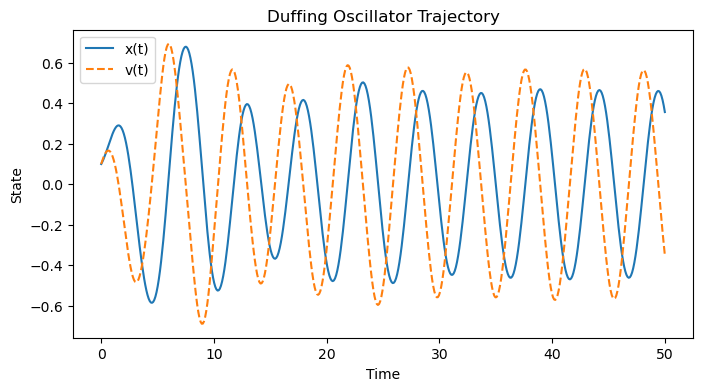

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import PolynomialFeatures

# Duffing oscillator parameters
alpha, beta, delta, gamma, omega = 1.0, -1.0, 0.2, 0.3, 1.2

def duffing(t, state):
    x, v = state  # state = [x, v] where v = dx/dt
    dxdt = v
    dvdt = -delta * v - alpha * x - beta * x**3 + gamma * np.cos(omega * t)
    return [dxdt, dvdt]

# Time range and initial conditions
t_span = (0, 50)
t_eval = np.linspace(t_span[0], t_span[1], 500)
x0 = [0.1, 0.1]

# Solve the ODE
sol = solve_ivp(duffing, t_span, x0, t_eval=t_eval, method='RK45')

# Extract solution
x, v = sol.y
t = sol.t

# Plot the trajectory
plt.figure(figsize=(8, 4))
plt.plot(t, x, label="x(t)")
plt.plot(t, v, label="v(t)", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend()
plt.title("Duffing Oscillator Trajectory")
plt.show()


In [88]:
# Construct state vectors: X (current states) and Y (next states)
X = np.vstack((x[:-1], v[:-1])).T  # [x_k, v_k]
Y = np.vstack((x[1:], v[1:])).T    # [x_{k+1}, v_{k+1}]

# Apply polynomial feature mapping (EDMD basis functions)
poly = PolynomialFeatures(degree=5, include_bias=False)
X_lift = poly.fit_transform(X)  # Lift to higher-dimensional space
Y_lift = poly.transform(Y)      # Apply same transformation to Y

# Compute Koopman operator via least-squares regression
L = np.linalg.lstsq(X, Y, rcond=None)[0]
K = np.linalg.lstsq(X_lift, Y_lift, rcond=None)[0]

print("DMD operator shape:", L.shape)
print("Koopman operator shape:", K.shape)


DMD operator shape: (2, 2)
Koopman operator shape: (20, 20)


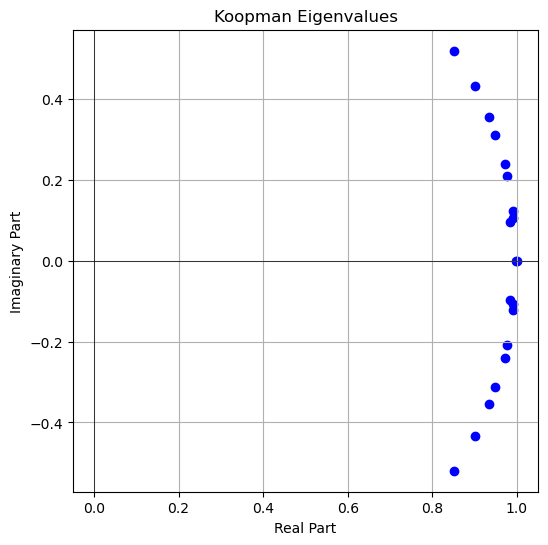

In [7]:
# Compute Koopman eigenvalues and modes
eigvals, eigvecs = np.linalg.eig(K)

# Sort eigenvalues by magnitude
idx = np.argsort(np.abs(eigvals))[::-1]
eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

# Plot eigenvalues
plt.figure(figsize=(6, 6))
plt.scatter(eigvals.real, eigvals.imag, color="blue", marker="o")
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Koopman Eigenvalues")
plt.grid()
plt.show()


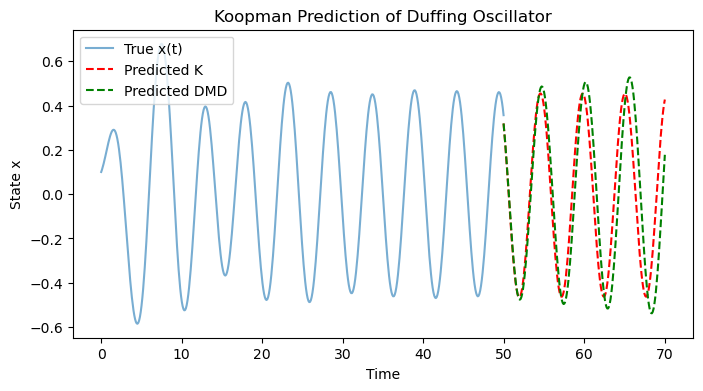

In [14]:
# Function to predict future states using the Koopman operator
def predict_koopman(K, initial_state, poly, steps):
    """
    Predict future states using Koopman operator K.

    Parameters:
    - K: Learned Koopman operator
    - initial_state: Initial condition [x, v]
    - poly: PolynomialFeatures transformer used in training
    - steps: Number of prediction steps

    Returns:
    - Predicted states over time
    """
    # Initialize prediction array
    predictions = np.zeros((steps, 2))
    current_state = initial_state

    for i in range(steps):
        # Lift the current state
        current_lifted = poly.transform(current_state.reshape(1, -1))

        # Predict next lifted state using Koopman operator
        next_lifted = current_lifted @ K

        # Project back to state space (first two entries correspond to x, v)
        predictions[i] = next_lifted[0, :2]

        # Update current state for next iteration
        current_state = predictions[i]

    return predictions

def predict_DMD(L, initial_state, steps):
    """
    Predict future states using Koopman operator K.

    Parameters:
    - K: Learned Koopman operator
    - initial_state: Initial condition [x, v]
    - poly: PolynomialFeatures transformer used in training
    - steps: Number of prediction steps

    Returns:
    - Predicted states over time
    """
    # Initialize prediction array
    predictions = np.zeros((steps, 2))
    current_state = initial_state

    for i in range(steps):
        next_state = current_state @ L

        # Project back to state space (first two entries correspond to x, v)
        predictions[i] = next_state

        # Update current state for next iteration
        current_state = predictions[i]

    return predictions

# Define number of steps to predict
num_steps = 200

# Start from last observed state
initial_state = np.array([x[-1], v[-1]])

# Predict using Koopman operator
predictions_K = predict_koopman(K, initial_state, poly, num_steps)
predictions_DMD = predict_DMD(L, initial_state, num_steps)

# Time axis for predictions
t_pred = np.linspace(t[-1], t[-1] + (t[1] - t[0]) * num_steps, num_steps)

# Plot true vs predicted trajectories
plt.figure(figsize=(8, 4))
plt.plot(t, x, label="True x(t)", linestyle="-", alpha=0.6)
plt.plot(t_pred, predictions_K[:, 0], label="Predicted K", linestyle="dashed", color="red")
plt.plot(t_pred, predictions_DMD[:, 0], label="Predicted DMD", linestyle="dashed", color="green")
plt.xlabel("Time")
plt.ylabel("State x")
plt.legend()
plt.title("Koopman Prediction of Duffing Oscillator")
plt.show()


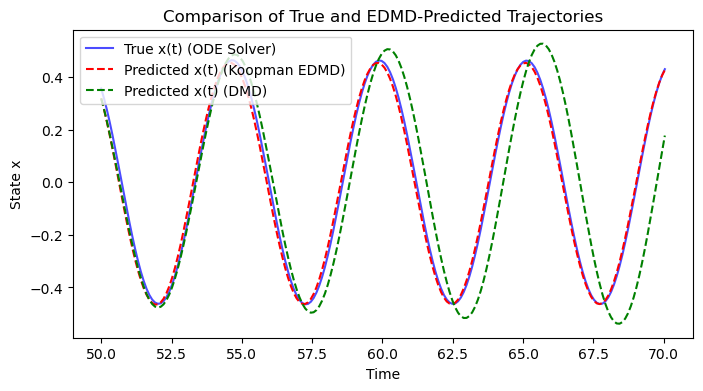

In [13]:
# Solve the Duffing ODE forward in time for comparison
t_span_pred = (t[-1], t[-1] + (t[1] - t[0]) * num_steps)
t_eval_pred = np.linspace(t_span_pred[0], t_span_pred[1], num_steps)

# Integrate the ODE using the last observed state as initial condition
sol_pred = solve_ivp(duffing, t_span_pred, initial_state, t_eval=t_eval_pred, method='RK45')

# Extract the true future trajectory
x_true, v_true = sol_pred.y
t_true = sol_pred.t

plt.figure(figsize=(8, 4))
plt.plot(t_true, x_true, label="True x(t) (ODE Solver)", linestyle="-", alpha=0.7, color="blue")
plt.plot(t_pred, predictions_K[:, 0], label="Predicted x(t) (Koopman EDMD)", linestyle="dashed", color="red")
plt.plot(t_pred, predictions_DMD[:, 0], label="Predicted x(t) (DMD)", linestyle="dashed", color="green")
plt.xlabel("Time")
plt.ylabel("State x")
plt.legend()
plt.title("Comparison of True and EDMD-Predicted Trajectories")
plt.show()



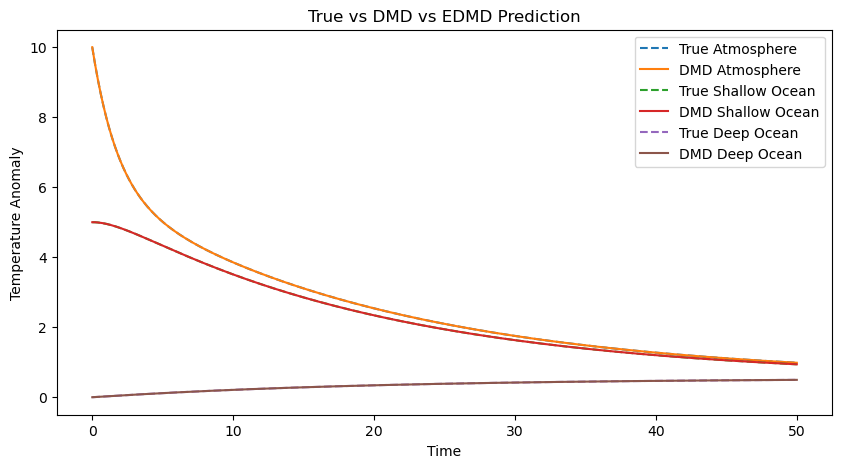

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, pinv, expm
from sklearn.preprocessing import PolynomialFeatures


# Define system parameters
c = np.array([1.0, 10.0, 100.0])  # Heat capacities (atmosphere, shallow ocean, deep ocean)
L = np.array([[-0.5, 0.5, 0.0],  # Atmosphere exchanges with shallow ocean
              [0.5, -1.0, 0.5],  # Shallow ocean exchanges with both
              [0.0, 0.5, -0.5]]) # Deep ocean exchanges with shallow ocean
L /= c[:, None]  # Normalize by heat capacities

# Time discretization
dt = 0.1
T_max = 50
t_vals = np.arange(0, T_max + dt, dt)

# Solve the system numerically
T = np.zeros((3, len(t_vals)))  # Temperature states
T0 = [10, 5, 0]
T[:,0] = T0

for i in range(1, len(t_vals)):
    T[:,i] = T[:,i-1] + dt * (L @ T[:,i-1])  # Forward Euler

# Collect DMD snapshots
X = T[:,:-1]  # Data at time t
X_prime = T[:,1:]  # Data at time t+1
L_tilde = X_prime @ pinv(X)

# Predict future states using DMD
T_dmd = np.zeros_like(T)
T_dmd[:,0] = T[:,0]
for i in range(1, len(t_vals)):
    #T_dmd[i,:] = T_dmd[i-1,:] + dt * (L_tilde @ T_dmd[i-1,:] + np.array([F[i], 0, 0]))  # Forward Euler
    T_dmd[:,i] = L_tilde @ T_dmd[:,i-1]  # Forward Euler

# Plot results
plt.figure(figsize=(10, 5))
labels = ['Atmosphere', 'Shallow Ocean', 'Deep Ocean']
for i in range(3):
    plt.plot(t_vals, T[i,:], label=f'True {labels[i]}', linestyle='dashed')
    plt.plot(t_vals, T_dmd[i,:], label=f'DMD {labels[i]}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature Anomaly')
plt.title('True vs DMD vs EDMD Prediction')
plt.show()


In [124]:
L_tilde

array([[ 9.50000000e-01,  5.00000000e-02,  8.88178420e-16],
       [ 5.00000000e-03,  9.90000000e-01,  5.00000000e-03],
       [-2.77555756e-16,  5.00000000e-04,  9.99500000e-01]])

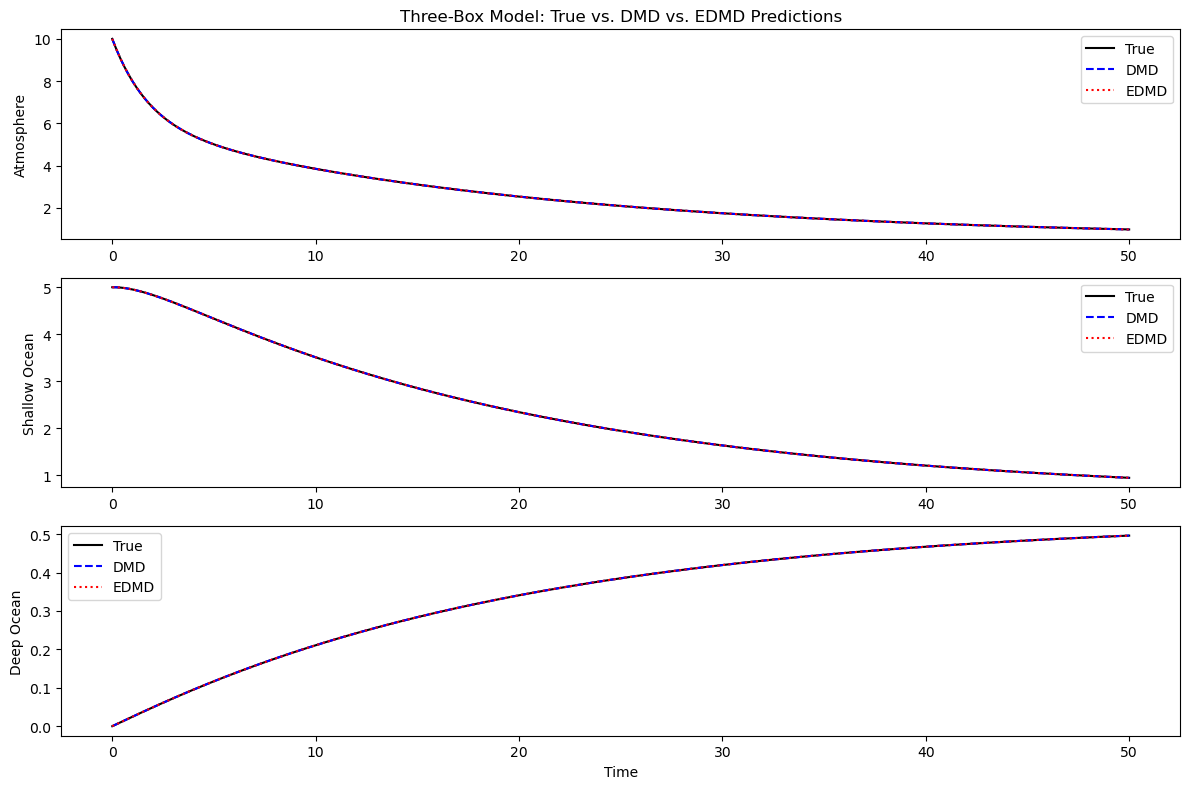

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd, pinv

# -----------------------------
# Define the three-box model
# -----------------------------

# Heat capacities for (atmosphere, shallow ocean, deep ocean)
c = np.array([1.0, 10.0, 100.0])

# Heat exchange operator L (only boxes 1-2 and 2-3 communicate)
L = np.array([
    [-0.5,  0.5,  0.0],
    [ 0.5, -1.0,  0.5],
    [ 0.0,  0.5, -0.5]
])

# Construct the system matrix A where dT/dt = A T.
# Each row i is divided by c[i].
A = np.zeros_like(L)
for i in range(3):
    A[i, :] = L[i, :] / c[i]

# -----------------------------
# Time Discretization & Integration
# -----------------------------
dt = 0.1
t_max = 50
t_vals = np.arange(0, t_max + dt, dt)
n_steps = len(t_vals)

# Initialize solution array for the true solution (using forward Euler)
T_true = np.zeros((3, n_steps))
# Set initial condition: box 1 hottest, box 2 moderate, box 3 coolest.
T0 = np.array([10, 5, 0])
T_true[:, 0] = T0

# Integrate using a forward Euler method
for k in range(1, n_steps):
    T_true[:, k] = T_true[:, k-1] + dt * (A @ T_true[:, k-1])

# -----------------------------
# DMD Implementation
# -----------------------------
# Construct snapshot matrices X and X_prime
X2 = T_true[:, :-1]      # Each column is T(t_k)
X2_prime = T_true[:, 1:]  # Each column is T(t_{k+1})

# Compute the best-fit linear operator: K_dmd such that X_prime ≈ K_dmd * X
K_dmd = X2_prime @ pinv(X2)

# Use K_dmd to predict the evolution from the initial condition
T_dmd = np.zeros_like(T_true)
T_dmd[:, 0] = T0
for k in range(1, n_steps):
    T_dmd[:, k] = K_dmd @ T_dmd[:, k-1]

# -----------------------------
# EDMD Implementation
# -----------------------------
# Define a polynomial (quadratic) lifting function.
def lift_state(state):
    """
    Lifts a 3D state into a 9D observable space.
    The basis functions are:
      - Linear: T1, T2, T3
      - Quadratic: T1^2, T2^2, T3^2, T1*T2, T1*T3, T2*T3
    """
    T1, T2, T3 = state
    return np.array([T1, T2, T3,
                     T1**2, T2**2, T3**2,
                     T1*T2, T1*T3, T2*T3])

def lift_data(data):
    """
    Applies the lift_state function column-wise.
    Input:
      data: 3 x N array (each column is a state)
    Output:
      lifted: 9 x N array of observables.
    """
    N = data.shape[1]
    lifted = np.zeros((9, N))
    for i in range(N):
        lifted[:, i] = lift_state(data[:, i])
    return lifted

# Lift the snapshot matrices
X_lift = lift_data(X)           # 9 x (n_steps-1)
X_prime_lift = lift_data(X_prime) # 9 x (n_steps-1)

# Solve for the EDMD Koopman operator in the lifted space:
K_edmd = X_prime_lift @ pinv(X_lift)

# Use the EDMD operator to predict evolution.
# Since our first three observables are the original state, we extract them.
T_edmd = np.zeros((3, n_steps))
T_edmd[:, 0] = T0
current_lift = lift_state(T0)  # initial lifted state, 9-dimensional
for k in range(1, n_steps):
    current_lift = K_edmd @ current_lift
    # The predicted state is taken as the first three entries.
    T_edmd[:, k] = current_lift[:3]

# -----------------------------
# Plotting the Results
# -----------------------------
labels = ['Atmosphere', 'Shallow Ocean', 'Deep Ocean']
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t_vals, T_true[i, :], 'k-', label='True')
    plt.plot(t_vals, T_dmd[i, :], 'b--', label='DMD')
    plt.plot(t_vals, T_edmd[i, :], 'r:', label='EDMD')
    plt.ylabel(labels[i])
    if i == 0:
        plt.title('Three-Box Model: True vs. DMD vs. EDMD Predictions')
    if i == 2:
        plt.xlabel('Time')
    plt.legend()
plt.tight_layout()
plt.show()


In [129]:
print(np.linalg.norm(T_true - T_dmd))
print(np.linalg.norm(T_true - T_edmd))

1.780634288354028e-11
3.6844414150749123e-10


In [132]:
np.linalg.eig(L)

EigResult(eigenvalues=array([-5.55000000e-01, -5.00000000e-02, -1.70702299e-19]), eigenvectors=array([[-0.99400386, -0.74124932,  0.57735027],
       [ 0.10934043, -0.66712438,  0.57735027],
       [-0.000994  ,  0.07412493,  0.57735027]]))

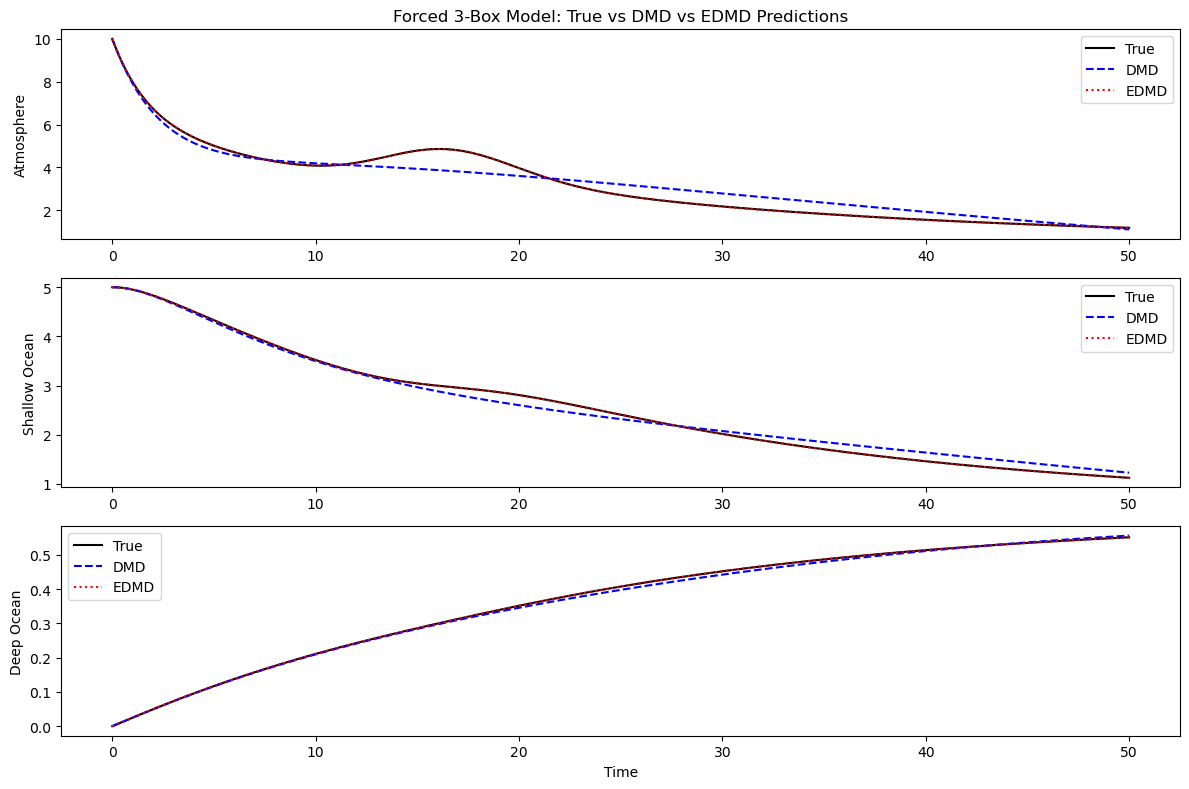

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinv
from sklearn.preprocessing import PolynomialFeatures

# -----------------------------
# Model Parameters
# -----------------------------
# Heat capacities (atmosphere, shallow ocean, deep ocean)
c = np.array([1.0, 10.0, 100.0])

# Coupling matrix L (only adjacent boxes communicate)
L = np.array([
    [-0.5,  0.5,  0.0],
    [ 0.5, -1.0,  0.5],
    [ 0.0,  0.5, -0.5]
])
# System matrix A: each row i divided by c[i]
A = np.zeros_like(L)
for i in range(3):
    A[i, :] = L[i, :] / c[i]

# Forcing function: Gaussian forcing acting on the atmosphere
def gaussian_forcing(t, t0=15, sigma=3):
    return np.exp(-((t - t0) ** 2) / (2 * sigma ** 2))

# -----------------------------
# Time Integration
# -----------------------------
dt = 0.1
T_max = 50
t_vals = np.arange(0, T_max + dt, dt)
n_steps = len(t_vals)

# Allocate arrays for temperatures and forcing
T_true = np.zeros((3, n_steps))
F_true = np.zeros(n_steps)

# Initial condition: out-of-equilibrium temperatures (box1 hottest, box3 coolest)
T0 = np.array([10, 5, 0])
T_true[:, 0] = T0
F_true[0] = gaussian_forcing(t_vals[0])

# Integrate the forced system using forward Euler:
# dT/dt = A T + [F(t), 0, 0]
for k in range(1, n_steps):
    F_true[k] = gaussian_forcing(t_vals[k])
    forcing_vec = np.array([F_true[k], 0, 0])
    T_true[:, k] = T_true[:, k-1] + dt * (A @ T_true[:, k-1] + forcing_vec)

# Create extended state: [T1, T2, T3, F]
X_extended = np.vstack((T_true, F_true))  # shape: (4, n_steps)

# -----------------------------
# DMD on Augmented State
# -----------------------------
# Construct snapshot matrices (each column is a state vector)
X_dmd    = X_extended[:, :-1]
X_prime_dmd = X_extended[:, 1:]

# Compute the best-fit linear operator for DMD: X' ≈ K_dmd * X
K_dmd = X_prime_dmd @ pinv(X_dmd)

# Predict forward using DMD:
X_dmd_pred = np.zeros_like(X_extended)
X_dmd_pred[:, 0] = X_extended[:, 0]
for k in range(1, n_steps):
    X_dmd_pred[:, k] = K_dmd @ X_dmd_pred[:, k-1]

# Extract predicted temperatures (first three components)
T_dmd = X_dmd_pred[:3, :]

# -----------------------------
# EDMD on Augmented State
# -----------------------------
# Use a quadratic polynomial lift for the 4-dimensional extended state.
# (The first four entries of the lifted vector are the original state.)
poly = PolynomialFeatures(degree=2, include_bias=False)

# Lift the snapshot matrices. (Transpose so that each row is one sample.)
X_edmd    = poly.fit_transform(X_dmd.T).T       # shape: (n_features, n_steps-1)
X_prime_edmd = poly.transform(X_prime_dmd.T).T

# Compute the Koopman operator in the lifted space:
K_edmd = X_prime_edmd @ pinv(X_edmd)

# Predict forward using EDMD:
# Start by lifting the initial extended state:
current_lift = poly.transform(X_extended[:, 0].reshape(1, -1))[0]
lift_dim = current_lift.shape[0]
X_edmd_pred = np.zeros((lift_dim, n_steps))
X_edmd_pred[:, 0] = current_lift
for k in range(1, n_steps):
    X_edmd_pred[:, k] = K_edmd @ X_edmd_pred[:, k-1]

# Reconstruct the extended state by taking the first 4 entries (the linear part)
X_edmd_reconstructed = X_edmd_pred[:4, :]
T_edmd = X_edmd_reconstructed[:3, :]

# -----------------------------
# Plot the Results
# -----------------------------
labels = ['Atmosphere', 'Shallow Ocean', 'Deep Ocean']
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t_vals, T_true[i, :], 'k-', label='True')
    plt.plot(t_vals, T_dmd[i, :], 'b--', label='DMD')
    plt.plot(t_vals, T_edmd[i, :], 'r:', label='EDMD')
    plt.ylabel(labels[i])
    if i == 0:
        plt.title('Forced 3-Box Model: True vs DMD vs EDMD Predictions')
    if i == 2:
        plt.xlabel('Time')
    plt.legend()
plt.tight_layout()
plt.show()


In [454]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinv

# ------------------------------------------------------------------------
# 1) Dictionary Class for Modular Lifting
# ------------------------------------------------------------------------
class Dictionary:
    def __init__(self, method="polynomial", **kwargs):
        """
        Initialize the dictionary with a chosen method.

        Available methods:
        - 'polynomial': Polynomial basis up to 'degree'
        - 'rbf': Radial basis functions with 'centers' and 'gamma'
        """
        self.method = method
        self.params = kwargs

    def transform(self, X):
        """
        Lift input X into a higher-dimensional space.
        X should be shape (N_samples, N_features).
        Returns shape (N_samples, N_lifted_features).
        """
        if self.method == "polynomial":
            return self._poly_dictionary(X, self.params.get("degree", 2))
        elif self.method == "poly_cross":
            return self._poly_cross_dictionary(X, self.params.get("degree", 2))
        elif self.method == "rbf":
            return self._rbf_dictionary(X,
                                        self.params.get("centers", None),
                                        self.params.get("gamma", 1.0))
        else:
            raise ValueError(f"Unknown dictionary method: {self.method}")

    def _poly_dictionary(self, X, degree=2):
        """Simple polynomial features up to 'degree' (no cross-terms)."""
        N, D = X.shape
        # Start with constant term
        Phi = [np.ones(N)]
        # Add powers of each feature up to 'degree'
        for d in range(1, degree+1):
            for i in range(D):
                Phi.append(X[:, i]**d)
        return np.vstack(Phi).T

    def _poly_cross_dictionary(self, X, degree=2):
        """
        Polynomial features including cross terms up to 'degree' = 2.
        e.g. for D=3, we get:
          [1, x1, x2, x3, x1^2, x2^2, x3^2, x1*x2, x1*x3, x2*x3].
        Extend similarly if you need higher degrees.
        """
        N, D = X.shape
        Phi = [np.ones(N)]  # constant term

        if degree >= 1:
            # linear terms: x1, x2, ...
            for i in range(D):
                Phi.append(X[:, i])
        if degree >= 2:
            # squares: x1^2, x2^2, ...
            for i in range(D):
                Phi.append(X[:, i]**2)
            # cross terms: x1*x2, x1*x3, etc.
            for i in range(D):
                for j in range(i+1, D):
                    Phi.append(X[:, i] * X[:, j])

        return np.vstack(Phi).T

    def _rbf_dictionary(self, X, centers=None, gamma=1.0):
        """Radial Basis Function dictionary with optional 'centers'."""
        N, D = X.shape
        if centers is None:
            # Create 5 equally spaced centers per dimension
            # (for illustration; adjust as needed)
            centers = []
            for dim in range(D):
                c_lin = np.linspace(np.min(X[:,dim]), np.max(X[:,dim]), 5)
                centers.append(c_lin)
            # Create all combinations of centers across dimensions
            from itertools import product
            centers = np.array(list(product(*centers)))
        # Build RBF features
        Phi = [np.ones(N)]
        for center in centers:
            dist_sq = np.sum((X - center)**2, axis=1)
            Phi.append(np.exp(-gamma * dist_sq))
        return np.vstack(Phi).T


# ------------------------------------------------------------------------
# 2) Three-Box Model Integration with Known Forcing B
# ------------------------------------------------------------------------
# Heat capacities
c = np.array([1.0, 10.0, 100.0])

# Coupling matrix L
L = np.array([
    [-0.5,  0.5,  0.0],
    [ 0.5, -1.0,  0.5],
    [ 0.0,  0.5, -0.5]
])
# Construct continuous-time system matrix A
A_ct = np.zeros_like(L)
for i in range(3):
    A_ct[i, :] = L[i, :] / c[i]

# Forcing enters only the atmosphere (box 1)
gamma = np.array([[1.0], [0.0], [0.0]])

def gaussian_forcing(t, t0=15, sigma=3):
    return np.exp(-((t - t0)**2)/(2*sigma**2))

def sinusoidal_forcing(t, freq=0.2):
    return np.sin(2*np.pi*freq*t)

def integrate_3box(forcing_func, dt=0.1, T_max=50, x0=np.array([10,5,0])):
    """
    Integrate the forced 3-box model using forward Euler in discrete time.
    x_{k+1} = x_k + dt * (A_ct x_k + B u_k)
    Returns (t_vals, X, U).
    """
    t_vals = np.arange(0, T_max+dt, dt)
    n_steps = len(t_vals)
    X = np.zeros((3, n_steps))
    U = np.zeros((1, n_steps))
    X[:,0] = x0

    for k in range(1, n_steps):
        u_k = forcing_func(t_vals[k])
        U[0, k] = u_k
        X[:, k] = X[:, k-1] + dt * (A_ct @ X[:, k-1] + gamma.flatten()*u_k)
    return t_vals, X, U


In [445]:
def dmdc_train(F, X):
  F = np.hstack((F.T, np.zeros((F.shape[1], 2))))

  Omega = np.concatenate([X[:,:-1],F[:-1,:].T])
  L = X[:,1:] @ np.linalg.pinv(Omega)
  n = len(X)

  A, B = L[:,:n], L[:,n:]
  return A, B

def edmdc_train(F, X, dictionary):
  F = np.hstack((F.T, np.zeros((F.shape[1], 2))))

  Phi_F = dictionary.transform(F[:-1,:])
  Phi_X = dictionary.transform(X[:,:-1].T)
  Phi_Xprime = dictionary.transform(X[:,1:].T)

  Omega = np.concatenate([Phi_X.T,Phi_F.T])
  K = Phi_Xprime.T @ np.linalg.pinv(Omega)
  n = len(Phi_Xprime.T)

  A, B = K[:,:n], K[:,n:]
  return A, B


In [450]:
def dmdc_predict(F, A, B, x0, n_steps):

  # Allocate
  X_pred = np.zeros((x0.shape[0], n_steps))
  X_pred[:, 0] = x0

  # For storing the reconstructed state
  X_rec = np.zeros((3, n_steps))

  # We'll fill first step
  X_rec[:, 0] = x0

  F = np.hstack((F.T, np.zeros((F.shape[1], 2)))).T

  for k in range(1, n_steps):
    # Discrete-time update in lifted space
    X_pred[:, k] = A @ X_pred[:, k-1] + B @ F[:,k-1]

  return X_pred

def edmdc_predict(F, A, B, dictionary, x0, n_steps):

  # x0 is shape (3,)
  # Convert to (1,3) for dictionary.transform
  Phi0 = dictionary.transform(x0.reshape(1, -1))  # shape (1, n_lifted)
  Phi0 = Phi0.flatten()                            # (n_lifted,)

  # Allocate
  Phi_pred = np.zeros((Phi0.shape[0], n_steps))
  Phi_pred[:, 0] = Phi0

  # For storing the reconstructed state
  X_rec = np.zeros((3, n_steps))

  # We'll fill first step
  X_rec[:, 0] = x0

  F = np.hstack((F.T, np.zeros((F.shape[1], 2))))
  Phi_F = dictionary.transform(F[:-1,:]).T

  for k in range(1, n_steps):
    # Discrete-time update in lifted space

    Phi_pred[:, k] = A @ Phi_pred[:, k-1] + B @ Phi_F[:,k-1]

    # Reconstruct the state from the first 3 dimensions
    X_rec[:, k] = Phi_pred[1:4, k]  # depends on how dictionary is defined

  return X_rec

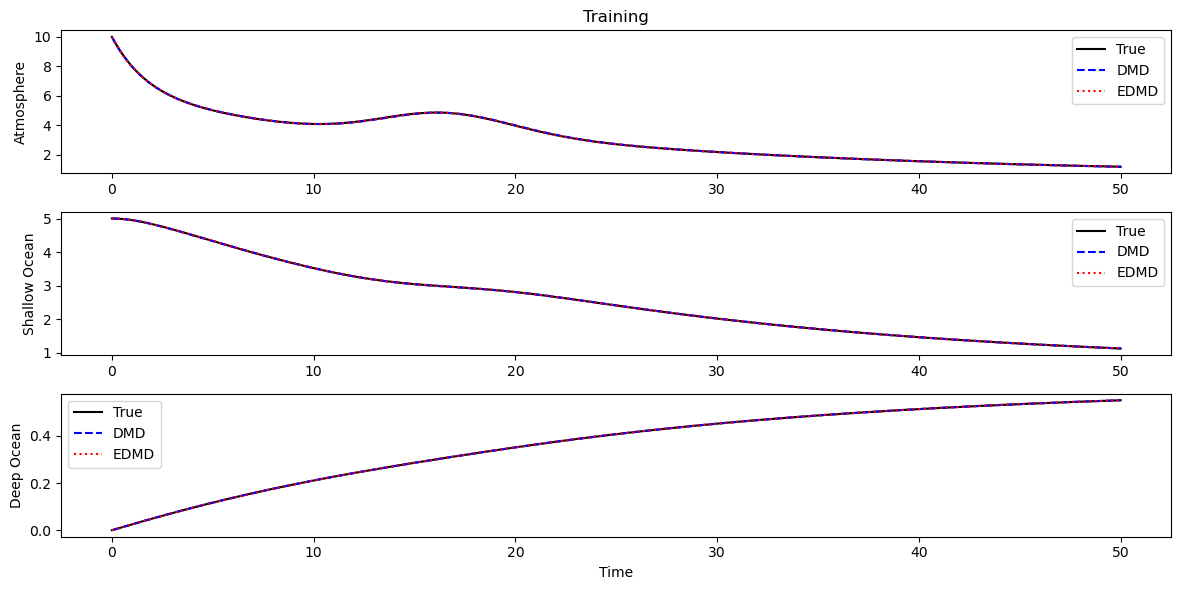

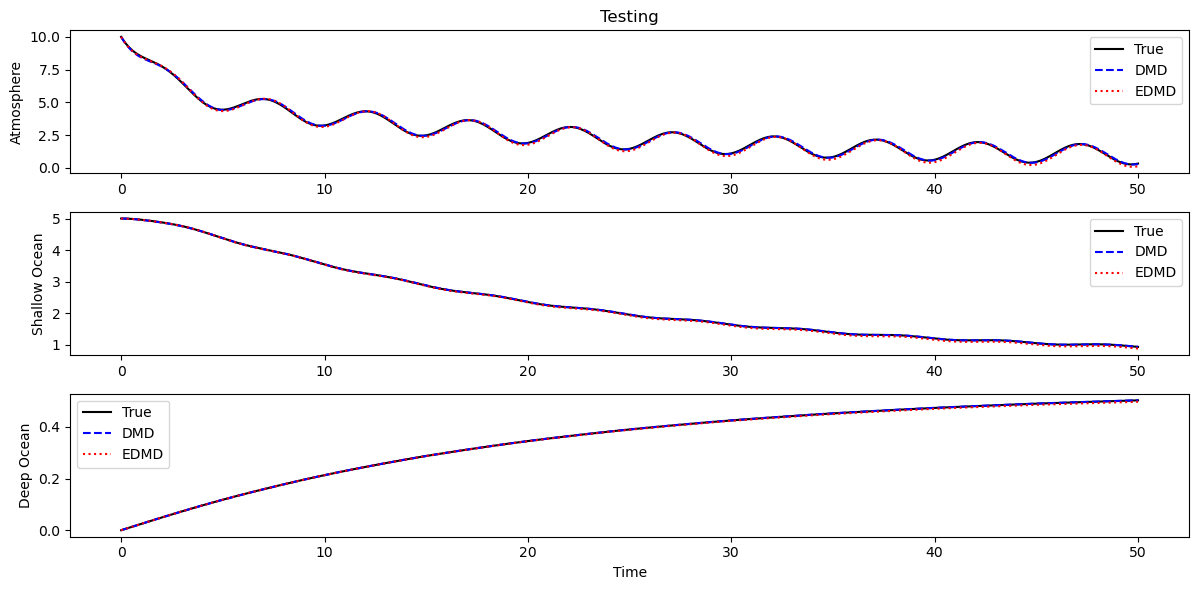

0.22683954813169982 0.0880930055429265
1.4248603823402552 22.794788363946108


In [474]:
dt = 0.1
t_max = 50
t_vals = np.arange(0, t_max + dt, dt)
n_steps = len(t_vals)
x0 = np.array([10, 5, 0])
dictionary = Dictionary(method='polynomial', degree=2)

t_train, X_train, F_train = integrate_3box(gaussian_forcing, dt, t_max, x0)
#t_train, X_train, F_train = integrate_3box(sinusoidal_forcing, dt, t_max, x0)
A_dmdc, B_dmdc = dmdc_train(F_train, X_train)
A_edmdc, B_edmdc = edmdc_train(F_train, X_train, dictionary)

X_dmdc_train = dmdc_predict(F_train, A_dmdc, B_dmdc, x0, n_steps)
X_edmdc_train = edmdc_predict(F_train, A_edmdc, B_edmdc, dictionary, x0, n_steps)

t_test, X_test_true, F_test = integrate_3box(sinusoidal_forcing, dt, t_max, x0)
#t_train, X_test_true, F_test = integrate_3box(gaussian_forcing, dt, t_max, x0)
n_test = X_test_true.shape[1]
X_dmdc_test = dmdc_predict(F_test, A_dmdc, B_dmdc, x0, n_steps)
X_edmdc_test = edmdc_predict(F_test, A_edmdc, B_edmdc, dictionary, x0, n_steps)

labels = ['Atmosphere', 'Shallow Ocean', 'Deep Ocean']

# --- Training Performance ---

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t_train, X_train[i, :], 'k-', label=f'True')
    plt.plot(t_train, X_dmdc_train[i, :], 'b--', label=f'DMD')
    plt.plot(t_train, X_edmdc_train[i, :], 'r:', label='EDMD')
    plt.ylabel(labels[i])
    if i == 0:
        plt.title('Training')
    if i == 2:
        plt.xlabel('Time')
    plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(t_train, X_test_true[i, :], 'k-', label=f'True')
    plt.plot(t_train, X_dmdc_test[i, :], 'b--', label=f'DMD')
    plt.plot(t_train, X_edmdc_test[i, :], 'r:', label='EDMD')
    plt.ylabel(labels[i])
    if i == 0:
        plt.title('Testing')
    if i == 2:
        plt.xlabel('Time')
    plt.legend()
plt.tight_layout()
plt.show()

print(np.linalg.norm(X_train - X_dmdc_train), np.linalg.norm(X_train - X_edmdc_train))
print(np.linalg.norm(X_test_true - X_dmdc_test), np.linalg.norm(X_train - X_edmdc_test))